In [6]:
#@title Files for Import
import_file = "mlwpy.py" #@param {type:"string"}

#import libraries
import re
import importlib

#create regex
find = re.compile(r"^(.*?)\..*")
# extract file name before .py ending
import_file_no_ext = re.search(find, import_file).group(1)

# copy file to the current notebook
!cp '/content/drive/MyDrive/Colab Notebooks/imports/{import_file}' .
# import module
module = importlib.import_module(import_file_no_ext)

# is there an __all__? if so import all
if '__all__' in module.__dict__:
    names = module.__dict__['__all__']
else:
    # otherwise import all names that don't begin with _
    names = [x for x in module.__dict__ if not x.startswith('_')]

# now bring them in
globals().update({k: getattr(module, k) for k in names})

print(f'Imported file: {import_file_no_ext}.py')

# set matplotlib to display inline
%matplotlib inline

Imported file: mlwpy.py


In [7]:
#save default font settings
IPython_default = plt.rcParams.copy()

# set fonts / set text size
#@title matplotlib font settings
small_text = 15 #@param {type:"integer"}
medium_text = 26 #@param {type:"integer"}
large_text = 28 #@param {type:"integer"}
line_marker_size = 5 #@param {type:"slider", min:0, max:10, step:0.5}
legend_shadow = True #@param {type:"boolean"}
fig_width =  8 #@param {type:"number"}
fig_height =  6 #@param {type:"number"}
sns_style = "ticks" #@param ["darkgrid", "whitegrid", "dark", "white", "ticks"]
axis_grid = True #@param {type:"boolean"}
sns_palette = "deep" #@param ["pastel", "muted", "bright", "deep", "colorblind", "dark"]

import matplotlib.pyplot as plt
import seaborn as sns

# restore defaults
plt.rcdefaults()

#run configuration parameters
plt.rcParams['axes.labelsize']   = small_text
plt.rcParams['axes.titlesize']   = small_text
plt.rcParams['xtick.labelsize']  = small_text
plt.rcParams['ytick.labelsize']  = small_text
plt.rcParams['legend.fontsize']  = small_text
plt.rcParams['legend.shadow']    = legend_shadow
plt.rcParams['lines.markersize'] = line_marker_size
plt.rcParams['figure.figsize']   = (fig_width, fig_height)
plt.rcParams['font.size']        = small_text

# seaborn settings
sns.set_style(sns_style, {"axes.grid": axis_grid})
sns.set_palette(sns_palette)

# enable wordwrap
#https://stackoverflow.com/questions/58890109/line-wrapping-in-collaboratory-google-results
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
    td,th,p {
        font-size: 18px
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

# 15.1 Optimization

When we try to find a best line, curve, or tree to match our data, which is the main goal in training, we want to have an automated method do the work for us. We do this by assessing our cost and looking for ways to lower the cost. Cost is a combination of the loss, how well our model's predictions match the training data, and the complexity of the model. By minimizing cost, we try to achieve a small loss while keeping a low complexity. We cannot always get to the ideal, but that's our goal.

When training a learning model, one of th eeasiest aprameters to think about is the weights, from linear or logistic regression, that we combine with the feature values to get predictions. Since we get to adjust the weights, we look at the effect of adjusting them and see what happens to the cost. If we have a definition of the cost, a cost *function*, perhaps drawn as a graph, we can turn the adjusting process into a question. From where we are, from our current weights and the cost we get by using them, what small adjustments to the weights can we make? Is there a direction that we can go that will result in a *lower* cost? a way to think about this visually is to ask what direction is *downhill* on our cost function. Let's look at an example.

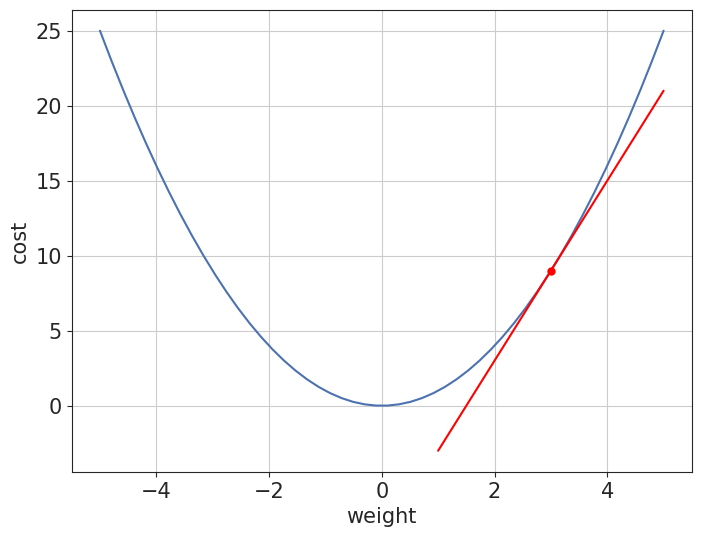

In [8]:
xs = np.linspace(-5,5)
ys = xs**2

fig, ax = plt.subplots(1,1)
ax.plot(xs, ys)

# better Python:
# pt = co.namedtuple('Point', ['x', 'y'])(3,3**2)
pt_x, pt_y = 3, 3**2
ax.plot(pt_x, pt_y, 'ro')

line_xs = pt_x + np.array([-2, 2])
# line ys = mid_point + (x amount) * slope_of_line
# one step right gets one "slope of line" increase in that line's up
line_ys = 3**2 + (line_xs - pt_x) * (2 * pt_x)
ax.plot(line_xs, line_ys, 'r-')
ax.set_xlabel('weight')
ax.set_ylabel('cost');

If we put an imaginary ball at the red dot, it would roll downward to the left. The red line represents the *slope,* how steep the blue graph is--at that point. You can imagein that if we are trying to find a low point, we want to follow the slope. It is reasonable to be *more confident* in our direction if the slope is steeper. If we can roll down the hill faster if there is a steeper slope. If we do that, here's one take on what can happen.

From the starting point of weight = 3 that we just saw, we can take a step down the hill by moving to the left. We'll take a step that is moderated by the slope at our current point. Then we repeat the process. We try this ten times and see what happens. We could have picked the starting point randomly and we'd be pretty lucky if it were the minimum.

Approximate location of blue graph minimum: 0.0029296875


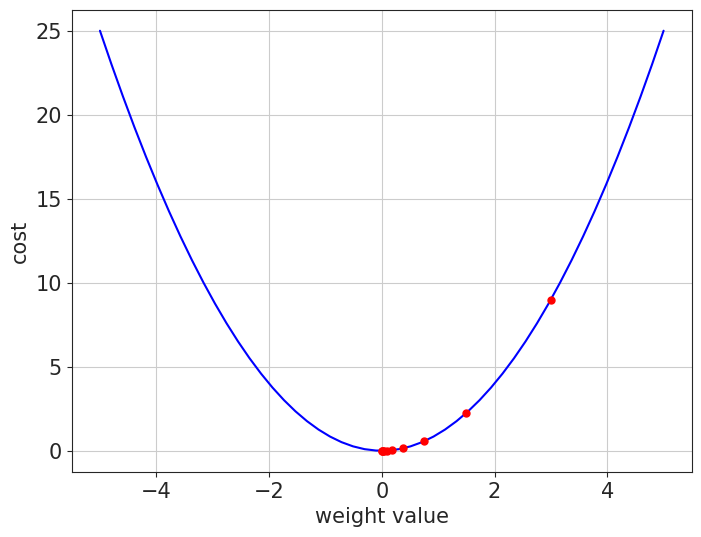

In [9]:
weights = np.linspace(-5,5)
costs  = weights**2

fig, ax = plt.subplots(1,1)
ax.plot(weights, costs, 'b')

# current best guess at the minimum
weight_min = 3

# we follow the path downhill from our starting point
# and find out the weights value where our initial, blue graph is
# (approximately) the lowest
for i in range(10):
    # for a weight, we can figure out the cost
    cost_at_min = weight_min**2
    ax.plot(weight_min, cost_at_min, 'ro')

    # also, we can figure out the slope (steepness)
    # via a magic incantation called a "derivative")
    slope_at_min = 2 * weight_min

    # new best guess made by walking downhill
    step_size = .25
    weight_min = weight_min - step_size * slope_at_min

ax.set_xlabel('weight value')
ax.set_ylabel('cost')
print('Approximate location of blue graph minimum:', weight_min)    

We gradually approach the weight = 0 wieght is the actual minimum of the blue curve defined by $weight^2$. In this example, we never really went past the low point because we took small steps (based on the `step_size=.25` in the `weight_min` assignment). You imagine that if we took slightly bigger steps, we might shoot beyond the low point. That's OK. Then, we would recognize that the downhill direction is now *to the right* and we can follow that path down. There are many details that we are sweeping under the carpet, but we can eventually settle in on the low point. In reality, we might only get a value very close to zero--0.00000000001, perhaps--but that is probably good enough.

We can apply many different strategies to find the minimum .We don't have to do the downhill walking by hand, or even code ti by hand. The general basket of techniques to do this is called *mathematical optmization*. We make use of one optimizer that is built into `scipy`, called `fmin`. Since that is a really boring name, we call it the `magical_minimum_finder.`

In [10]:
from scipy.optimize import fmin as magical_minimum_finder
def f(x):
    return x**2

magical_minimum_finder(f, [3], disp=False)    

array([-0.])

From a starting point of `3`, `magical_minimum_finder` was able to locate the input value to `f` that resulted in the lowest ouput value. That result is analogous to what we want if we have weights as the inputs and a cost as the ouput. We now have one tool to use for finding minimum costs.

## 15.2 Linear Regression from Raw Materials

Now that we have a tool to minimize functions,  we can *build a linear regression* system using that tool. Let's step back to a 40,000-foot view of learning. When we try to *learn* something, we try to *fit* the *parameters* of a *model* to some *training data*. In linear regression, our parameters are weights (*m, b* or $w_i$) that we manipulate to make the *features* match the *target*. 

Let's get started by creating some sythetic data. We pull a +1 trick. We add a column of ones to data as opposed to putting the +1 in the model.

In [11]:
linreg_ftrs_p1 = np.c_[np.arange(10), np.ones(10)] # +1 trick in data

true_wgts = m,b = w_1, w_0 = 3,2
linreg_tgt = rdot(true_wgts, linreg_ftrs_p1)

linreg_table = pd.DataFrame(linreg_ftrs_p1,
                            columns=['ftr_1', 'ones'])
linreg_table['tgt'] = linreg_tgt
linreg_table[:10]

,ftr_1,ones,tgt
0,0.0000,1.0000,2.0000
1,1.0000,1.0000,5.0000
2,2.0000,1.0000,8.0000
3,3.0000,1.0000,11.0000
4,4.0000,1.0000,14.0000
5,5.0000,1.0000,17.0000
6,6.0000,1.0000,20.0000
7,7.0000,1.0000,23.0000
8,8.0000,1.0000,26.0000
9,9.0000,1.0000,29.0000


We made a super simple dataset that only has a single interesting features. It's complicated enough that we can't get the answer, the right weights for a fit model, for free. We *could* by peeking at the code we used to create the data, but we won't do taht. Instead, to find good weights, we'll pull out `magical_minimum_finder` to do the heavy lifting. To use `magical_minimum_finder`, we have to define the *loss* that we get from our *predictions* versus the real state of the world in the target. We do this in several steps. We have to explicitly define our learning model and the loss. We also define an ultra simple weight penalty, none or *no* penalty, so we can make a full-fledged cost.

In [12]:
def linreg_model(weights, ftrs):
    return rdot(weights, ftrs)

def linreg_loss(predicted, actual):
    errors = predicted - actual
    return np.dot(errors, errors) # sum-of-squares

def no_penalty(weights):
    return 0.0        

When we used `magical_minium_finder`, we had to pass a Python function that took one, and only one, argument and it did all of its wonderful minimizing work. From that *single* argument, we have to somehow convince our function to make all the wonderful fit, loss, cost, weight, and train components of a learning method. To make this happen, we use a Python trick: we write one function that *produces another function* as its result. We did this in Section 11.2 when we created an adding function that added a specific value to an input value. Here, we'll use the same technique to wrap up the model, loss, penalty, and data components as a single function of the model parameters. The paramters are the weights we want to find.


In [13]:
def make_cost(ftrs, tgt, 
              model_func, loss_func,
              c_tradeoff, complexity_penalty):
    ' build an optimization problem from data, model, loss, penalty '
    def cost(weights):
        return (loss_func(model_func(weights, ftrs), tgt) +
                c_tradeoff * complexity_penalty(weights))
    return cost        

Let's see what happens when we try to use `make_cost` to build our cost function and then minimize it with `magical_minimum_finder`.

In [14]:
# build linear regression optimization problem
linreg_cost = make_cost(linreg_ftrs_p1, linreg_tgt,
                        linreg_model, linreg_loss,
                        0.0, no_penalty)
learned_wgts = magical_minimum_finder(linreg_cost, [5,5], disp=False)
print("   true weights:", true_wgts)
print("learned weights:", learned_wgts)

   true weights: (3, 2)
learned weights: [3. 2.]


Building the cost and magically finding the least cost weights led to exactly the true weights we started with. However, we still have not made use of a penalty. From chatper 9, we moved from a cost based on predicted targets to a loss based on those predictions plus a penalty for complex models. We did that to help overfitting. We can add complexity penalties to our `make_cost` process by defining something more interesting than our `no_penalty`. The two main penalties are $L_1$ and $L_2$ and we used them to make the lasso and ridge regression methods. We can build cost functions that effectively give us lasso and ridge regression. Here are the penalties we need.


In [15]:
def L1_penalty(weights):
    return np.abs(weights).sum()

def L2_penalty(weights):
    return np.dot(weights, weights)    

We can use those to make different cost functions:

In [16]:
linreg_L1_pen_cost = make_cost(linreg_ftrs_p1, linreg_tgt,
                               linreg_model, linreg_loss,
                               1.0, L1_penalty)
learned_wgts = magical_minimum_finder(linreg_L1_pen_cost, [5,5], disp=False)

print("     true weights:", true_wgts)
print("  learned weights:", learned_wgts)


     true weights: (3, 2)
  learned weights: [3.0212 1.8545]


This time we did not get the correct weights. Out training data had no noise in it. As result, the penalties on the weights actually hurt us. We can follow the same template to make ridge regression.

In [17]:
# linear regression with L2 regularization (ridge regression)
linreg_L2_pen_cost = make_cost(linreg_ftrs_p1, linreg_tgt,
                               linreg_model, linreg_loss,
                               1.0, L2_penalty)
learned_wgts = magical_minimum_finder(linreg_L2_pen_cost, [5,5], disp=False)

print("   True weights:", true_wgts)
print("learned weights:", learned_wgts)

   True weights: (3, 2)
learned weights: [3.0508 1.6102]


Again, we had perfect data so penalties don't do us any favors.

### 15.2.1 A Graphical View of Linear Regression

We can represent the computations we just perfomed as a flow of data through a graph. Figure 15.1 shows all the pieces in a visual form.

<img src="https://drive.google.com/uc?id=1BAQbLidmjwbCEjNQhlR8GYN6W1MvfBO4&authuser=scottminer1205%40gmail.com&usp=drive_fs" width=500/>

# 15.3 Building Logistic Regression from Raw Matericals

We built a simple linear regression model using som ePython coding tricks and `magical_minimum_finder`. We can do classification using the same steps: define a model and a cost. Then we minimize both. Done.

We start by generating synthetic data. The linear regression part of logistic regression was producing the log-odds. To get an actual class, we have to convert the log-odds into probabilities. If we're interested in the target classes, we can *use* those probabilities to pick classes. However, when we select a random value and compare it to a probability, we don't get a *guaranteed* result. We have a probability of a result. It's a random process that is inherently noisy. So, unlike the noiseless regression data we used above, we might see benefits from regularization.

In [18]:
logreg_ftr = np.random.uniform(5,15,size=(100,))
true_wgts = m,b = -2, 20
line_of_logodds = m*logreg_ftr + b
prob_at_x = np.exp(line_of_logodds) / (1 + np.exp(line_of_logodds))

logreg_tgt = np.random.binomial(1, prob_at_x, len(logreg_ftr))
logreg_ftrs_p1 = np.c_[logreg_ftr,
                       np.ones_like(logreg_ftr)]
logreg_table = pd.DataFrame(logreg_ftrs_p1,
                            columns=['ftr_1','ones'])
logreg_table['tgt'] = logreg_tgt
display(logreg_table.head())                       

,ftr_1,ones,tgt
0,8.7454,1.0000,1
1,14.5071,1.0000,0
2,12.3199,1.0000,0
3,10.9866,1.0000,0
4,6.5602,1.0000,1


Graphically, the classes-and their probabilities--look like the following:

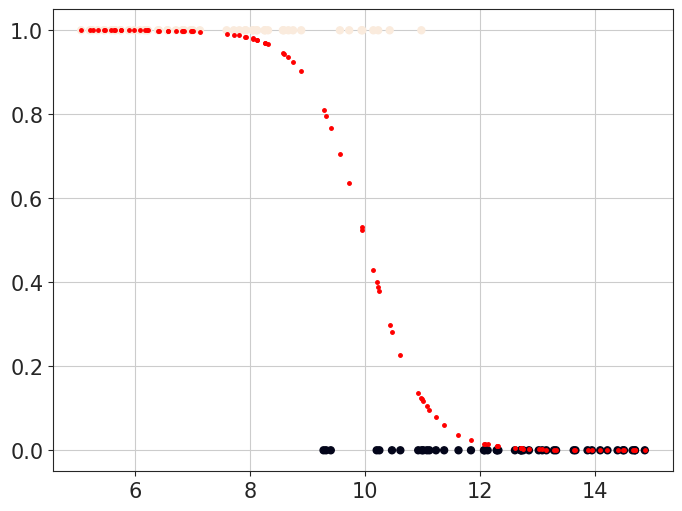

In [19]:
fig, ax = plt.subplots(1,1)
ax.plot(logreg_ftr, prob_at_x, 'r.')
ax.scatter(logreg_ftr, logreg_tgt, c=logreg_tgt);

Here, there are two classes, 0 and 1, represented by the yellow and purple dots. The yellow dots fall on the horizontal line at $y = 1$ and the purple dots fall on the horizontal line at $y = 0$. We begin with pure 1s and as the input feature gets bigger, the likelihood of class 1 falls off and we see a mix of 1 and 0. Eventually, we see only 0s. The mix of outcomes is controlled by the probabilities given by the red dots on the curving path that falls from one to zero. 

On the far left, we are flipping a coin that has an almost 100% chance of coming up 1, and you'll notice that we have lots of 1 outcomes. On the right-hand side, the red dots are all near zero, we have almost a zero percent chance of coming up with a 1. In the middle, we have moderate probabilities of comping up with ones and zeros. Between 9 and 11 we get some 1s and some 0s. 

Creating synthetic data like this may give you a better idea of where and what the logistic regression log-odds, probabilities, and classes come from. More practically, the data is just hard enough to classify to make it interesting. Let's see how to classify it with `magical_minimum_finder.`

### 15.3.1 Logistic Regression with Zero-One Coding

Predicting the log-odds is really *the same* as the linear regression model. The difference comes in how we assess our loss. The loss we use has many different names: logistic loss, log-loss, or cross-entropy loss. It measures the agreement we see in the training data and our predictions. Here's the loss for one prediction:

$$ \text{log_loss} = -p_{actual}\log(p_{pred}) - (1 - p_{actual})\log(1 - p_{pred})$$

$p_{actual}$ is known, since we know the target class. $p_{pred}$ is unknown and can wave gradually from 0 to 1. If we put that loss together with target values of zero and one and shake it up with some algebra, we get another expression translated into code `logreg_loss_01`.

In [20]:
# for logistic regression
def logreg_model(weights, ftrs):
    return rdot(weights, ftrs)

def logreg_loss_01(predicted, actual):
    # sum(-actual log(predicted) - (1-actual) log(1-predicted))
    # for 0/1 target works out to
    return np.sum(- predicted * actual + np.log(1+np.exp(predicted)))    

Here we have our model and loss. Does it work?

In [21]:
logreg_cost = make_cost(logreg_ftrs_p1, logreg_tgt,
                        logreg_model, logreg_loss_01,
                        0.0, no_penalty)
learned_wgts = magical_minimum_finder(logreg_cost, [5,5], disp=False)
print('   true weights:', true_wgts)
print('learned weights:', learned_wgts)

   true weights: (-2, 20)
learned weights: [-1.9774 19.8659]


Not bad. Not as exact as with good old-fashioned linear regression, but pretty close. Can you think of why? It's because there is noise in the samples, considering the middle part of the sigmoid above. Let's see if regularization helps.

In [22]:
# logistic regression with penalty
logreg_pen_cost = make_cost(logreg_ftrs_p1, logreg_tgt,
                            logreg_model, logreg_loss_01,
                            0.5, L1_penalty)
learned_wgts = magical_minimum_finder(logreg_pen_cost, [5,5], disp=False)
print(f'   true weights: {true_wgts}')
print(f'learned weights: {learned_wgts}')

   true weights: (-2, 20)
learned weights: [-1.2809 12.7875]


The weights are different and have gone the *wrong* way. However, we simply picked our tradeoff between prediction accuracy and complexity `C` out of a hat. We shouldn't read too much into this. It's a simple dataset. There aren't too many data points, and we only tried one value of `C`. Can you find a better `C`?

### 15.3.2 Logistic Regression with Plus-One Minus-One Coding

Before we leave logistic regression, let's add one last twist. There shouldn't be any difference between having classes that are *cat* and *dog* or *donkey* and *elephant* or *zero* and *one*, or *+one* and *-one*. Let's take a quick look at logistic regression with $\pm1$. The only difference is that we need a different loss function. Before that, however, let's make a helper to deal with converting 01 data to $\pm1$ data.

In [23]:
def binary_to_pm1(b):
    ' map {0,1} or {False,True} to {-1, +1} '
    return (b*2) -1
binary_to_pm1(0), binary_to_pm1(1)    

(-1, 1)

Here, we update the loss function to work with the $\pm1$ data. We start with the same log loss expression we had above, work through some slightly different algebra using the $\pm1$ values, and get the `logreg_loss_pm1`. The two `logreg_loss` functions are just slightly different code expressions of the same mathematical idea.

In [24]:
# for logistic regression
def logreg_model(weights, ftrs):
    return rdot(weights, ftrs)

def logreg_loss_pm1(predicted, actual):
    # -actual log(predicted) - (1-actual) log(1-predicted)
    # for +1/-1 targets, works out to:
    return np.sum(np.log(1+np.exp(-predicted*actual)))    

With a model and a loss, we can perform our magical minimization to find good weights.

In [25]:
logreg_cost = make_cost(logreg_ftrs_p1, binary_to_pm1(logreg_tgt),
                        logreg_model, logreg_loss_pm1,
                        0.0, no_penalty)
learned_wgts = magical_minimum_finder(logreg_cost, [5,5], disp=False)
print(f'   true weights: {true_wgts}')
print(f'learned weights: {learned_wgts}')

   true weights: (-2, 20)
learned weights: [-1.9774 19.8659]


While the weights are nice, I'm curious about what sort of classification performance these weights give us. Let's take a quick look. We need to convert the weights into actual classes. We do that with another helper that knows how to convert weights into probabiliities and then into classes.

In [26]:
def predict_with_logreg_weights_to_pm1(w_hat, x):
    prob = 1 / (1 + np.exp(rdot(w_hat, x)))
    thresh = prob < .5
    return binary_to_pm1(thresh)

preds = predict_with_logreg_weights_to_pm1(learned_wgts, logreg_ftrs_p1)
print(metrics.accuracy_score(preds, binary_to_pm1(logreg_tgt)))    

0.93


Good enough. Even if the weights are not perfect, they might be useful for prediction.

### 15.3.3 A Graphical View of Logistic Regression

We can look at logistic regression in the same graphical way we looked at the mathematics of the linear regression. The one piece that is a bit more complicated in the logistic regression is the $\frac{1}{1+e^{LO}}$ form. That is the logistic or sigmoid function. If we're content using the name "logistic" to represent that function, we can draw the mathematical relationships in Figure 15.2.

<img src="https://drive.google.com/uc?id=1BGOi0EA52Lyu_6RR-dVJi5W9sNVU6xfs&authuser=scottminer1205%40gmail.com&usp=drive_fs" width=500/>

# 15.4 SVM from Raw Materials

We can do the same process on WVM when we built it from primitive components. Again, the only difference is that we have a slightly differnt loss function.

In [27]:
# for SVC
def hinge_loss(predicted, actual):
    hinge = np.maximum(1-predicted*actual, 0.0)
    return np.sum(hinge)

def predict_with_svm_weights(w_hat, x):
    return np.sign(rdot(w_hat,x)).astype(np.int)    

SVM works well with $\pm1$ data. Since the SVM model is *just* the dot product, we won't bother giving it a special name.

In [28]:
svm_ftrs = logreg_ftrs_p1
svm_tgt = binary_to_pm1(logreg_tgt) # svm "demands" +/- 1

# svm model is "just" rdot, so we don't define it separately now
svc_cost = make_cost(svm_ftrs, svm_tgt, rdot,
                     hinge_loss, 0.0, no_penalty)
learned_weights = magical_minimum_finder(svc_cost, [5,5], disp=False)
preds = predict_with_svm_weights(learned_weights, svm_ftrs)
print('no penalty accuracy:',
      metrics.accuracy_score(preds, svm_tgt))

no penalty accuracy: 0.91


As we did with logistic regression, we can add a penalty term to control the weights.

In [29]:
svc_pen_cost = make_cost(svm_ftrs, svm_tgt, rdot,
                         hinge_loss, 1.0, L1_penalty)
learned_weights = magical_minimum_finder(svc_pen_cost, [5,5], disp=False)
preds = predict_with_svm_weights(learned_weights, svm_ftrs)
print('accuracy with penalty:',
      metrics.accuracy_score(preds, svm_tgt))

accuracy with penalty: 0.91


Now is a great time to give you a warning. We are using trivial *true* relatoinships with tiny amounts of easy-to-separeate data. You shouldn't expect to use `scipy.optimize.fmin` for *real-world* problems. With the warning aside, here's a way to think about the optimization that *is* performed by the techniques you *would* use. From this perspective, wehn you use SVM, you are using a nice customer optimizer that works well for SVM problems. The same is true for linear and logistic regression: some ways of optimizing, finding the minimum cost paraemters--work well for particular learning methods, so under the hood we *use that method*! In reality, customized techniques can solve specific optimization problems, such as those we need to solve when we fit a model, better than generic techniques like `fmin`. You don't have to worry about it until you start (1) using the absolute latest learning methods that are coming out of research journals or (2) implementing customized learning methods yourself. One quick note. In reality, we didn't actually get to the kernelized version that takes us from SVCs to SVMs. Everything is basically the same, excep we replace our dot products with kernels.

## 15.5 Neural Networks

Neural networks are responsible for some of the coolest advances in learning in the past decade, but they have been around for a long time. The first mathematical discussion of them started up in the 1940s. Moving toward the 1960s, neural nets started a pattern of boom-bust cycles. 

### 15.5.1 A NN View of Linear Regression

We start with linear regression as our prototype for developing a neural network. We can redraw the diagram in a slightly different way.

<img src="https://drive.google.com/uc?id=1BpwVG3oKRp3UYE6OzpFeUB9DENA5-cEW&authuser=scottminer1205%40gmail.com&usp=drive_fs" width=500/>

To implement the diagram, we use `keras`. In turn, `keras` drives a lower-level neural network in TensorFlow. They massively simplify the process of turning diagrams of NN components into executable programs.

In [37]:
import tensorflow.keras.layers as kl
import tensorflow.keras.models as km
import tensorflow.keras.optimizers as ko

`keras` models can be defined and built in a number of ways. A simple one that allows for adding layers is the `add` method. The process is sequential. Classic linear regression only requires one *work* layer, which connects inputs and the outputs (which are layers in their own right).

In Keras, we define the working layer as a `Dense` layer, meaning that we connect *all* of the incoming components together (densely). Further, we create it as a `Dense(1)` layer. This means that we connect *all* of the incoming components together into *one* node. The values funnel through the single node and form a dot product. By specifying `activation='linear'`, we are specifying a a classic linear regression model.

The last piece in the model is how we optimize it. We need to define our cost/loss function and the technique we use to minimize it. We use a mean-squared-error loss (`loss='mse'`) and a rolling-downhill optimizer called *stochastic gradient descent* (`ko.SGD`). The *gradient descent* part is the downhill bit. The *stochastic* part means we are only using a part of our training data instead of *all* of it, everytime we try to figure out the downhill direction. The technique is useful when there is a large amount of training data. We use `lr` (learning rate) in the same way we used `step_size` in Section 15.1: once we know a direction, we need to know how far to move in that direction. 

In [41]:
def Keras_LinearRegression(n_ftrs):
    model = km.Sequential()
    # Dense layer defaults include a "bias" (a +1 trick)
    model.add(kl.Dense(1,
                       activation='linear',
                       input_dim=n_ftrs))
    model.compile(optimizer=ko.SGD(learning_rate=0.01), loss='mse')
    return model

The `keras` models have the same basic API as `sklearn`. A call to `fit` and `predict` will get predictions. One slight difference is that `fit` returns a history of the fitting run.

In [42]:
# for various reasons, we are going to let Keras do the +1 trick
# we will *not* send the `ones` feature
linreg_ftrs = linreg_ftrs_p1[:,0]

linreg_nn = Keras_LinearRegression(1)
history = linreg_nn.fit(linreg_ftrs, linreg_tgt, epochs=1000, verbose=0)
preds = linreg_nn.predict(linreg_ftrs)

mse = metrics.mean_squared_error(preds, linreg_tgt)
print("Training MSE: {:5.4f}".format(mse))

Training MSE: 0.0000


Therefore, we took the training error down to very near zero. Be warned: that's a *training* evaluation, not a *testing* evaluation. We can dive into the fitting history to see how the proverbial ball rolled down the cost curve. We just look at the first five steps below. When we specified `epochs=1000` we were specifying 1000 steps.

In [43]:
history.history['loss'][:5]

[162.94418334960938,
 28.777599334716797,
 5.591559886932373,
 1.5789000988006592,
 0.8787595629692078]

Just a few steps made a massive amount of progress in driving down the loss.

### 15.5.2 A NN View of Logistic Regression

The NN diagrams for linear regression and logistic regression are *very* similar. The only visible difference is the wavy sigmoid curve on the logistic regression side. The only difference when we go to implement logistic regression is the `activation` parameter. Above, for linear regression, we used a `linear` activation, which was just a dot product. For logistic regression, we use a `sigmoid` activation which basically pipes a dot product through a sigmoid curve. Once we put that together with a different loss function, we use the los loss under the name `binary_crossentropy`), we're *done*. However, we're only done because the output is a probability. We have to convert that to a class by comparing with `.5`.

<img src="https://drive.google.com/uc?id=1C7qkKImdr00ak_BqcR0M6z_5DIY4z0kD&authuser=scottminer1205%40gmail.com&usp=drive_fs" width=500/>

In [44]:
def Keras_LogisticRegression(n_ftrs):
    model = km.Sequential()
    model.add(kl.Dense(1,
                       activation='sigmoid',
                       input_dim=n_ftrs))
    model.compile(optimizer=ko.SGD(), loss='binary_crossentropy')
    return model

logreg_nn = Keras_LogisticRegression(1)
history = logreg_nn.fit(logreg_ftr, logreg_tgt, epochs=1000, verbose=0)

# output is a probability
preds = logreg_nn.predict(logreg_ftr) > .5
print('accuracy:', metrics.accuracy_score(preds, logreg_tgt))

accuracy: 0.9


### 15.5.3 Beyond Basic Neural Networks

The single `Dense(1)` layer of NNs for linear and logistic regression is enough to get us started with basic--shallow--models, but the real power of NNs comes when we start having multiple nodes in a single layer, as in the figure below and when we start making *deeper* networks by adding layers.


 <img src="https://drive.google.com/uc?id=1C8rQezPqI7WfiL9aCgY6G7_MwbWSg5MZ&authuser=scottminer1205%40gmail.com&usp=drive_fs" width=500/>

`Dense(1, "linear")` only represents linearly separable Boolean targets. `Dense(n)` can represent *any* Boolean function but it might require a very large *n*. If we add layers, we continue representing any Boolean function, but we can, in some scenarios, do so with fewer and fewer total nodes. Fewer nodes means fewer weights or parameters that we have to adjust. We get simpler models, reduced overfitting, and more efficient training of our network.

As an example of where this leads, the MNIST handwritten digit recognition dataset, similar to `sklearn`'s `digits`, can be attacked with a multiple working-layer neural network. If we string together two `Dense(512)` layers, we get a network with about 670,000 weights that must be found via optimization. We can do that and get about a 98% accuracy. The most straightforward way to do that ends up losing some of the "imageness" of the images: we lose track of which pixels are next to each other, which is like losing word order in bag-of-words techniques. Therefore, we bring together another type of network connection--*convolution*--that keeps nearby pixels connected to each other, cutting down on irrelevant connections. Our *convolutoinal neural network* has only 300,000 parameters, but it can still perform similarly. Win-win. We effectively set 370,000 paramters to zero and have far fewer knobs left to adjust.

# 15.6.2 A PGM View of Linear Regression

Let's apply the idea of PGMs to linear regression.


###15.6.2.1 The Long Way

Here's how this works for GOF linear regression. We draw a model of how the features and weights interact. The drawing looks a lot like the model we drew for the neural network form of linear regression, with the addition of placeholder distributions for the learned weights.

<img src="https://drive.google.com/uc?id=1CFMVAu0Uey0okW5Qs222le6JnDYiMq2g&authuser=scottminer1205%40gmail.com&usp=drive_fs" width=700/>

The major tool for exploring PGMs is `pymc3`. The `mc` stands for Monte Carlo, a famous casino. When you see the name, you simply mentally substitute *randomness*.

In [47]:
import pymc3 as pm

# getting really hard to convince toolkits to be less verbose
import logging
pymc3_log = logging.getLogger('pymc3')
pymc3_log.setLevel(2**20)

When we predict a value with a linear regression, we really predict a *single* output target value that is a mean of the possible outcomes at that spot. If the data is not perfect, we have some wiggle room above and below the value. The wiggle room, which GOF linear regression treats as the same for each prediction, is a normal distribution. The normal distribution is centered at the predicted value with a standard deviation around the center, so it shows up as a band above and below the linear regression line. When we look at linear regression as PGM, we make this hidden detail *explicit* by specifying a standard deviation.

In [52]:
with pm.Model() as model:
    # boilerplate-ish setup of the distributions of our
    # guesses for things we don't know
    sd = pm.HalfNormal('sd', sd=1)
    intercept = pm.Normal('Intercept', 0, sd=10)
    ftr_1_wgt = pm.Normal('ftr_1_wgt', 0, sd=20)

    # outcomes made from initial guess and input data
    # this is y = mx + b in an alternate form
    preds = ftr_1_wgt * linreg_table['ftr_1'] + intercept

    #relatoinship between guesses, input data, and actual outputs
    # target = preds + noise(sd) (noise == tolerance around the line)
    target = pm.Normal('tgt',
                       mu=preds, sd=sd,
                       observed=linreg_table['tgt'])
    linreg_trace = pm.sample(1000, progressbar=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
